In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display as dp
import joblib
from hepler import *
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
import lightgbm as lgbm
from scipy.stats import loguniform
import warnings
from scipy import stats

warnings.simplefilter(action="ignore", category=FutureWarning)

#### 🎯 Notebook Goals:
1. Join all previous applications related tables on sk_id_prev.
2. Aggregate the joined table on sk_id_curr and pivot on loan_types.
3. Join with bureau and application table on sk_id_curr.
4. Use LGBM to select the most predictive features for modeling.

In [41]:
# primary_key: sk_id_prev
prev_df = joblib.load("data/prev_cleaned_df")
pos_df = joblib.load("data/pos_agg_df")
cc_df = joblib.load("data/cc_agg_df")
inst_df = joblib.load("data/inst_agg_df")

In [3]:
dp(prev_df.head(1))
dp(pos_df.head(1))
dp(cc_df.head(1))
dp(inst_df.head(1))

,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_down_payment,weekday_appr_process_start,hour_appr_process_start,nflag_last_appl_in_day,rate_down_payment,...,sellerplace_area,name_seller_industry,cnt_payment,name_yield_group,product_combination,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,nflag_insured_on_approval
0,2030495,271877,Consumer loans,1730.430054,17145.0,0.0,SATURDAY,15,1,0.0,...,35,Connectivity,12.0,3.0,POS mobile with interest,365243.0,-42.0,300.0,-42.0,0.0


,sk_id_prev,sk_id_curr,sk_dpd_sum,sk_dpd_mean,sk_dpd_def_sum,sk_dpd_def_mean,cnt_inst_org,total_months,contract_status,cnt_inst_decreases,cnt_inst_diff
0,1000001,158271,0,0.0,0,0.0,12.0,3,1.666667,True,True


,sk_id_prev,sk_id_curr,total_months,atm_draw_ratio_avg,pos_draw_ratio_avg,total_monthly_draw_avg,credit_lim_fin_org_ratio,total_still_owes,total_still_owes_int_princ_ratio,total_paid,total_interest_paid,interest_rate,pay_owe_ratio_total,pay_less_than_min_reg_avg,sk_dpd_sum,sk_dpd_mean,sk_dpd_def_sum,sk_dpd_def_mean,contract_stat,card_auto_pay_online
0,1000018,394447,5,0.183181,0.816819,29478.996875,3.0,136024.921875,0.022951,27708.75,-119686.234375,-0.81201,5.319438,0.0,0,0.0,0,0.0,2.0,0


,sk_id_prev,sk_id_curr,total_inst_count,fully_paid_ratio,delay_inst_ratio,delay_total_days,total_payment,total_pay_owe_diff,total_pay_owe_diff_ratio
0,1000001,158271,2,1.0,0.0,0.0,68443.42334,0.0,0.0


#### Join 4 tables on sk_id_prev:
- previous application  
- credit card
- pos cash loan
- instalment

In [4]:
prev_df.shape

(886099, 29)

In [42]:
prev_pos_df = prev_df.merge(
    pos_df, how="left", on="sk_id_prev", suffixes=("", "_pos_df")
)
prev_pos_df.shape

(886099, 39)

In [43]:
prev_pos_cc_df = prev_pos_df.merge(
    cc_df, how="left", on="sk_id_prev", suffixes=("", "_cc_df")
)

prev_pos_cc_df.shape

(886099, 58)

In [44]:
prev_pos_cc_inst_df = prev_pos_cc_df.merge(
    inst_df, how="left", on="sk_id_prev", suffixes=("", "_inst_df")
)
prev_pos_cc_inst_df.shape

(886099, 66)

joined table:

In [45]:
comb_df = prev_pos_cc_inst_df.copy()
comb_df = comb_df.drop(
    columns=["sk_id_curr_pos_df", "sk_id_curr_cc_df", "sk_id_curr_inst_df"]
)
bprint("Joined table shape: ")
print(comb_df.shape)
comb_df.head()


Joined table shape: 
(886099, 63)


,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_down_payment,weekday_appr_process_start,hour_appr_process_start,nflag_last_appl_in_day,rate_down_payment,...,sk_dpd_def_mean_cc_df,contract_stat,card_auto_pay_online,total_inst_count,fully_paid_ratio,delay_inst_ratio,delay_total_days,total_payment,total_pay_owe_diff,total_pay_owe_diff_ratio
0,2030495,271877,Consumer loans,1730.430054,17145.0,0.0,SATURDAY,15,1,0.0,...,NaN,NaN,NaN,1.0,1.0,0.000000,0.0,17284.275391,0.000000,0.000000
1,2802425,108129,Cash loans,25188.615234,607500.0,NaN,THURSDAY,11,1,NaN,...,NaN,NaN,NaN,5.0,1.0,0.000000,0.0,125943.076172,0.000000,0.000000
2,2523466,122040,Cash loans,15060.735352,112500.0,NaN,TUESDAY,11,1,NaN,...,NaN,NaN,NaN,9.0,1.0,0.111111,1.0,135546.618164,0.000000,0.000000
3,2819243,176158,Cash loans,47041.335938,450000.0,NaN,MONDAY,7,1,NaN,...,NaN,NaN,NaN,11.0,1.0,0.000000,0.0,563133.382812,0.000000,0.000000
4,1383531,199383,Cash loans,23703.929688,315000.0,NaN,SATURDAY,8,1,NaN,...,NaN,NaN,NaN,18.0,1.0,0.000000,0.0,530447.533203,111114.628906,0.209473


Adjust weekday feature to is_weekend

In [46]:
comb_df["weekday_appr_process_start"] = comb_df.weekday_appr_process_start.apply(
    lambda i: 1 if i in ["SUNDAY", "SATURDAY"] else 0
)

comb_df = comb_df.rename(columns={"weekday_appr_process_start": "is_weekend"})

##### Fill the NaN of different loan types

Since we joined the tables of different loan products with different \
features, there are nulls that should actually represent `not applicable`. 

For example applications that are cash loans are getting null in \
credit card loan features. We should not leave the nulls for model to impute \
because cash loans are not supposed to have credit card features. 

These nulls would be labeled for better interpretebility.

> Impute the nulls to -999999.

In [49]:
pos_id_ls = pos_df.sk_id_prev.tolist()
cc_id_ls = cc_df.sk_id_prev.tolist()

for i in pos_feat_ls:
    comb_df[i] = np.where(
        (comb_df[i].isna()) & (comb_df["sk_id_prev"].isin(cc_id_ls)),
        -999999,
        comb_df[i],
    )

for i in cc_feat_ls:
    comb_df[i] = np.where(
        (comb_df[i].isna()) & (comb_df["sk_id_prev"].isin(pos_id_ls)),
        -999999,
        comb_df[i],
    )

After the imputation, the pos_cash related features in the credit card loan \
columns show -999999 instead of null.

In [51]:
comb_df.loc[comb_df.sk_id_prev.isin(cc_id_ls)][pos_feat_ls]

,sk_dpd_sum,sk_dpd_mean,sk_dpd_def_sum,sk_dpd_def_mean,cnt_inst_org,total_months,contract_status,cnt_inst_decreases,cnt_inst_diff
16,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999,-999999
26,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999,-999999
40,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999,-999999
44,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999,-999999
59,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999,-999999
...,...,...,...,...,...,...,...,...,...
885985,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999,-999999
886018,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999,-999999
886021,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999,-999999
886071,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999,-999999


---

In [2]:
comb_df = joblib.load("data/comb_df")
comb_agg_df = joblib.load("data/comb_agg_df")
comb_agg_pivot_df = joblib.load("data/comb_agg_pivot_df")

#### Loan type and sk_id_curr aggregation and pivoting

There are different types of loans, in the separated dataframes:
- credit card
- pos cash

in the prev_df, there's
- consumer loans
- cash loans
- revolving loans

Both consumer_loans and cash_loans are in the pos_cash table, while the revolving \
loans are in the credit_card table.

##### Compare feature distribution of different loan types

📊 There are 3 different types of loans in historical records:

In [15]:
pd.DataFrame(comb_df.name_contract_type.value_counts())

,count
name_contract_type,
Consumer loans,537310
Cash loans,266381
Revolving loans,82408


Different loans have different distribution for some features, eg):

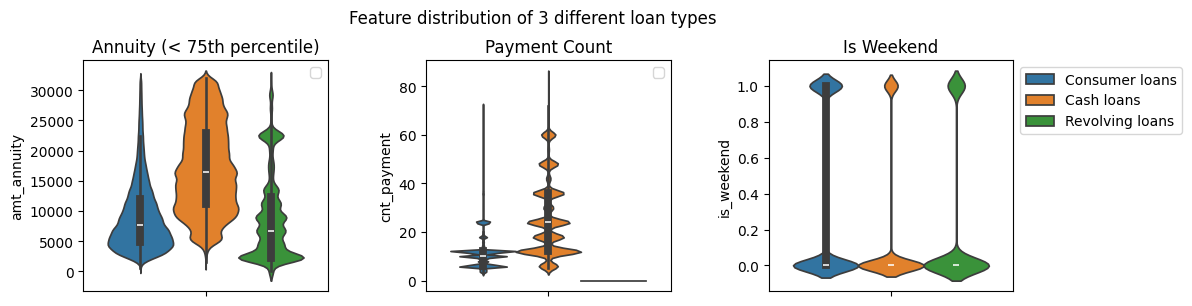

In [33]:
fig_size(12, 3)
plt.subplot(1, 3, 1)
plt.title("Annuity (< 75th percentile)")

sns.violinplot(
    data=comb_df.loc[comb_df.amt_annuity < 32000],
    y="amt_annuity",
    hue="name_contract_type",
)

plt.legend("")

plt.subplot(1, 3, 2)
plt.title("Payment Count")

sns.violinplot(
    data=comb_df,
    y="cnt_payment",
    hue="name_contract_type",
)
plt.legend("")

plt.subplot(1, 3, 3)
plt.title("Is Weekend")

sns.violinplot(
    data=comb_df,
    y="is_weekend",
    hue="name_contract_type",
)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.suptitle("Feature distribution of 3 different loan types", y=1.05)
plt.subplots_adjust(wspace=0.4)
plt.show()

📊 Hypothesis testing on loan types:

For modeling, we have to aggregate all the historical loans to sk_id_curr. 

Is the distribution of features similar across different loan types so we can \
aggregate all records together, or is there significant difference that makes \
it statistically incorrect to simply aggregate all of them together ?

H0: Features distribution have no significant difference among 3 different loan \
types.

Ha: Features distribution have significant difference among 3 different loan \
types.

alpha: 0.5

In [30]:
comb_agg_df = joblib.load("data/comb_agg_df")
hypo_df = comb_agg_df.replace(-999999, -1).fillna(-1).infer_objects()

cons_hypo_df = (
    hypo_df.loc[hypo_df.name_contract_type == "consumer_loans"]
    .iloc[:, 2:]
    .select_dtypes("float64")
)
cash_hypo_df = (
    hypo_df.loc[hypo_df.name_contract_type == "cash_loans"]
    .iloc[:, 2:]
    .select_dtypes("float64")
)
cc_hypo_df = (
    hypo_df.loc[hypo_df.name_contract_type == "revolving_loans"]
    .iloc[:, 2:]
    .select_dtypes("float64")
)


In [43]:
bprint("Kruskal-Wallis Test")
bprint(
    "Test whether there's significance difference among the 3 loan types feature distribution"
)
print("P_values of 60 features: ")

kk_pval_ls = []
for i in cons_hypo_df[:2]:
    cons = cons_hypo_df[i]
    cash = cash_hypo_df[i]
    cc = cc_hypo_df[i]
    kk = stats.kruskal(cons, cash, cc)

    kk_pval_ls.append(kk.pvalue)

print(kk_pval_ls)
bprint("==> All 60 features have p_value < 0.05 in the Kruskal-Wallis test.")

bprint(
    "Reject null hypothesis, there is significant difference among 3 loan types for all 60 features."
)


Kruskal-Wallis Test

Test whether there's significance difference among the 3 loan types feature distribution
P_values of 60 features: 
[0.0, 0.0, 0.0, 0.0, 0.0, 7.87576002969437e-45, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

==> All 60 features have p_value < 0.05 in the Kruskal-Wallis test.

Reject null hypothesis, there is significant difference among 3 loan types for all 60 features.


##### Aggregate and Pivot on different loan types

As the feature distribution of different loan types varies, if we simply \
aggregate on sk_id_curr, the aggregated features would be heavily distorted. 

However we still need to make sk_id_curr the primary key for the aggregated \
dataframe so it can be joined with the application dataframe.

Thus we would:

> First aggregate on `sk_id_curr + loan types`

> Then pivot on `loan types`

This way, each row would contain `different historical loan records` of the applicant.

##### Aggregate on `sk_id_curr + name_contract_type`: 

numerical features: take the mean \
categorical features: take the mode

- before aggregation:

In [189]:
comb_df.loc[comb_df.sk_id_curr == 108129]

,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_down_payment,is_weekend,hour_appr_process_start,nflag_last_appl_in_day,rate_down_payment,...,sk_dpd_def_mean_cc_df,contract_stat,card_auto_pay_online,total_inst_count,fully_paid_ratio,delay_inst_ratio,delay_total_days,total_payment,total_pay_owe_diff,total_pay_owe_diff_ratio
1,2802425,108129,Cash loans,25188.615234,607500.0,NaN,0,11,1,NaN,...,-999999.0,-999999.000000,-999999.0,5.0,1.0,0.000000,0.0,125943.076172,0.0,0.0
180670,1536272,108129,Cash loans,21709.125000,450000.0,NaN,0,9,1,NaN,...,-999999.0,-999999.000000,-999999.0,12.0,1.0,0.000000,0.0,649269.531250,0.0,0.0
313488,2068863,108129,Consumer loans,4830.930176,47250.0,24750.0,0,11,1,0.556485,...,-999999.0,-999999.000000,-999999.0,1.0,1.0,0.000000,0.0,25122.599609,0.0,0.0
329229,2551979,108129,Consumer loans,6664.274902,71352.0,0.0,0,9,1,0.000000,...,-999999.0,-999999.000000,-999999.0,12.0,1.0,0.000000,0.0,79906.273926,0.0,0.0
369303,2517198,108129,Revolving loans,11250.000000,0.0,NaN,0,13,1,NaN,...,0.0,1.952381,0.0,30.0,1.0,0.033333,6.0,322796.523933,0.0,0.0
733682,1760610,108129,Consumer loans,8593.964844,33052.5,0.0,1,10,1,0.000000,...,-999999.0,-999999.000000,-999999.0,2.0,1.0,0.000000,0.0,33971.804688,0.0,0.0


- after aggregation:

In [45]:
dp(comb_agg_df.loc[comb_agg_df.sk_id_curr == 108129])

bprint("shape:")
comb_agg_df.shape

,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_down_payment,is_weekend,hour_appr_process_start,nflag_last_appl_in_day,rate_down_payment,name_cash_loan_purpose,...,sk_dpd_def_mean_cc_df,contract_stat,card_auto_pay_online,total_inst_count,fully_paid_ratio,delay_inst_ratio,delay_total_days,total_payment,total_pay_owe_diff,total_pay_owe_diff_ratio
10953,108129,cash_loans,23448.871094,528750.0,NaN,0.0,10.0,1.0,NaN,NaN,...,-999999.0,-999999.0,-999999.0,8.5,1.0,0.0,0.0,387606.303711,0.0,0.0
10954,108129,consumer_loans,6696.390137,50551.5,8250.0,0.333333,10.0,1.0,0.185495,NaN,...,-999999.0,-999999.0,-999999.0,5.0,1.0,0.0,0.0,46333.559408,0.0,0.0
10955,108129,revolving_loans,11250.0,0.0,NaN,0.0,13.0,1.0,NaN,NaN,...,0.0,1.952381,0.0,30.0,1.0,0.033333,6.0,322796.523933,0.0,0.0



shape:


(480996, 62)

##### Pivot on `name_contract_type`: 

dataframe is converted from long_form to wide_form

- after pivot:

In [44]:
dp(comb_agg_pivot_df.loc[comb_agg_pivot_df.index == 108129])
bprint("shape:")
comb_agg_pivot_df.shape

,cash_loans_amt_annuity,consumer_loans_amt_annuity,revolving_loans_amt_annuity,cash_loans_amt_application,consumer_loans_amt_application,revolving_loans_amt_application,cash_loans_amt_down_payment,consumer_loans_amt_down_payment,revolving_loans_amt_down_payment,cash_loans_is_weekend,...,consumer_loans_total_payment,revolving_loans_total_payment,cash_loans_total_pay_owe_diff,consumer_loans_total_pay_owe_diff,revolving_loans_total_pay_owe_diff,cash_loans_total_pay_owe_diff_ratio,consumer_loans_total_pay_owe_diff_ratio,revolving_loans_total_pay_owe_diff_ratio,rej_history_count,rej_history_reason_mode
sk_id_curr,,,,,,,,,,,,,,,,,,,,,
108129,23448.871094,6696.390137,11250.0,528750.0,50551.5,0.0,NaN,8250.0,NaN,0.0,...,46333.559408,322796.523933,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN



shape:


(290065, 182)

##### Add the records of failed application

rejection history:

In [37]:
prev_refused_agg_df = joblib.load("data/prev_refused_agg_df")
prev_refused_agg_df.head(3)

,rej_count,rej_reason_mode
sk_id_curr,,
100006,1,LIMIT
100011,1,LIMIT
100027,1,HC


append it to the merged dataframe:

In [47]:
comb_agg_pivot_df = comb_agg_pivot_df.set_index("sk_id_curr")
comb_agg_pivot_df["rej_history_count"] = prev_refused_agg_df.rej_count
comb_agg_pivot_df["rej_history_reason_mode"] = prev_refused_agg_df.rej_reason_mode

comb_agg_pivot_df[["rej_history_count", "rej_history_reason_mode"]].tail(3)

,rej_history_count,rej_history_reason_mode
sk_id_curr,,
456253,NaN,NaN
456254,NaN,NaN
456255,2.0,HC


In [46]:
joblib.dump(comb_agg_pivot_df, "data/comb_agg_pivot_df")

['data/comb_agg_pivot_df']

---

In [8]:
comb_agg_pivot_df = joblib.load("data/comb_agg_pivot_df")
bu_agg_df = joblib.load("data/bu_agg_df")

#### Join bureau_agg_df on sk_id_curr

In [9]:
comb_agg_pivot_df.head(3)

,cash_loans_amt_annuity,consumer_loans_amt_annuity,revolving_loans_amt_annuity,cash_loans_amt_application,consumer_loans_amt_application,revolving_loans_amt_application,cash_loans_amt_down_payment,consumer_loans_amt_down_payment,revolving_loans_amt_down_payment,cash_loans_is_weekend,...,consumer_loans_total_payment,revolving_loans_total_payment,cash_loans_total_pay_owe_diff,consumer_loans_total_pay_owe_diff,revolving_loans_total_pay_owe_diff,cash_loans_total_pay_owe_diff_ratio,consumer_loans_total_pay_owe_diff_ratio,revolving_loans_total_pay_owe_diff_ratio,rej_history_count,rej_history_reason_mode
sk_id_curr,,,,,,,,,,,,,,,,,,,,,
100002,NaN,9251.775391,NaN,NaN,179055.0,NaN,NaN,0.0,NaN,NaN,...,219625.703125,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN
100003,98356.992188,35652.488281,NaN,900000.0,203154.75,NaN,NaN,3442.5,NaN,0.0,...,233943.657227,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN
100004,NaN,5357.25,NaN,NaN,24282.0,NaN,NaN,4860.0,NaN,NaN,...,21288.464844,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN


In [10]:
bu_agg_df.head(3)

,total_credit_count,active_credit_count,currency_1_ratio,days_credit_active_mean,credit_day_overdue_mean,credit_day_overdue_count,amt_credit_max_overdue_mean,cnt_credit_prolong_mean,amt_credit_sum_mean,amt_credit_sum_debt_mean,amt_annuity_mean,status_mean
sk_id_curr,,,,,,,,,,,,
100002,8,2,1.0,-874.00,0.0,8,1681.028931,0.0,108131.945312,49156.199219,0.0,0.299222
100003,4,1,1.0,-1400.75,0.0,4,0.000000,0.0,254350.125000,0.000000,NaN,NaN
100004,2,0,1.0,-867.00,0.0,2,0.000000,0.0,94518.898438,0.000000,NaN,NaN


In [70]:
comb_agg_pivot_df.shape, bu_agg_df.shape

((290065, 182), (263491, 12))

In [12]:
all_historical_feats_df = pd.concat([comb_agg_pivot_df, bu_agg_df], axis=1)

All historical credit records: 

In [21]:
all_historical_feats_df

,cash_loans_amt_annuity,consumer_loans_amt_annuity,revolving_loans_amt_annuity,cash_loans_amt_application,consumer_loans_amt_application,revolving_loans_amt_application,cash_loans_amt_down_payment,consumer_loans_amt_down_payment,revolving_loans_amt_down_payment,cash_loans_is_weekend,...,currency_1_ratio,days_credit_active_mean,credit_day_overdue_mean,credit_day_overdue_count,amt_credit_max_overdue_mean,cnt_credit_prolong_mean,amt_credit_sum_mean,amt_credit_sum_debt_mean,amt_annuity_mean,status_mean
sk_id_curr,,,,,,,,,,,,,,,,,,,,,
100002,NaN,9251.775391,NaN,NaN,179055.0,NaN,NaN,0.0,NaN,NaN,...,1.0,-874.000000,0.0,8.0,1681.028931,0.0,1.081319e+05,49156.199219,0.00000,0.299222
100003,98356.992188,35652.488281,NaN,900000.0,203154.75,NaN,NaN,3442.5,NaN,0.0,...,1.0,-1400.750000,0.0,4.0,0.000000,0.0,2.543501e+05,0.000000,NaN,NaN
100004,NaN,5357.25,NaN,NaN,24282.0,NaN,NaN,4860.0,NaN,NaN,...,1.0,-867.000000,0.0,2.0,0.000000,0.0,9.451890e+04,0.000000,NaN,NaN
100006,32100.255859,15755.219727,13500.0,564750.0,180914.671875,270000.0,NaN,34840.171875,NaN,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100007,17059.253906,2717.910156,NaN,213750.0,24090.75,NaN,NaN,3390.75,NaN,0.25,...,1.0,-1149.000000,0.0,1.0,0.000000,0.0,1.462500e+05,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,-929.703704,0.0,27.0,0.000000,0.0,2.251293e+05,85639.875000,2294.59082,0.000000
456155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,-1635.000000,0.0,1.0,NaN,0.0,8.938350e+04,0.000000,0.00000,0.000000
456177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,-482.000000,0.0,4.0,0.000000,0.0,1.241906e+06,729735.000000,NaN,NaN


clean up messy types:

- cast float64 -> float32
- cast obj -> category

In [52]:
all_historical_feats_df = all_historical_feats_df.infer_objects()
all_historical_feats_df = down_cast_float(all_historical_feats_df)
all_historical_feats_df = cast_typ_obj_to_cat(all_historical_feats_df)

In [59]:
joblib.dump(all_historical_feats_df, "data/all_historical_feats_df")

['data/all_historical_feats_df']

---

In [2]:
X_train = joblib.load("data/X_train_cleaned").reset_index()
y_train = joblib.load("data/y_train")
all_historical_feats_df = joblib.load(
    "data/all_historical_feats_df").reset_index()

cast obj type to category type 

In [11]:
X_train = cast_typ_obj_to_cat(X_train)
train_df = X_train.merge(all_historical_feats_df, on="sk_id_curr", how="left")
train_df = down_cast_float(train_df)
train_df["target"] = y_train

#### Feature Selection using LGBM

Up to now, we have together more than 300 features for modeling, some features \
might not be very useful, including them would create too much noise for the model.

> Here we'd use LGBM feature importance to select predictive features.

Sample 10,000 rows in train_df to be more efficient

In [6]:
train_df_sample = train_df.sample(100000, random_state=0)
train_df_sample = train_df_sample.fillna(np.nan)

X = train_df_sample.drop(columns=["target"])
y = train_df_sample.target.values

# model
base_model = LGBMClassifier(
    objective="binary", is_unbalance=True, seed=0, force_row_wise=True, verbose=-1
)

# params
params = {
    "lambda_l1": loguniform(0.001, 0.005),
    "feature_fraction": np.arange(0.4, 0.8, 0.1),
    "bagging_fraction": np.arange(0.3, 0.6, 0.1),
    "bagging_freq": np.arange(1, 3),
    "num_leaves": np.arange(48, 55),
    "max_depth": np.arange(1, 3),
    "learning_rate": [0.05, 0.1],
    "min_data_in_leaf": np.arange(160, 210, 10),
}

# randomized search for hyperparamter tuning
rs_model = RandomizedSearchCV(
    base_model,
    param_distributions=params,
    # cv=tuning_cv,
    n_iter=50,
    n_jobs=-1,
    random_state=3,
    scoring="average_precision",
)

# fit models (uncomment to run, takes appr. 10 min)
# model = rs_model.fit(X, y)
# best_model = model.best_estimator_

best_model = joblib.load("data/models/feat_selec_model")

# select features with importance > 0
selected_feats_ls = [
    i[0]
    for i in list(zip(best_model.feature_name_, best_model.feature_importances_))
    if i[1] > 0
]

joblib.dump(selected_feats_ls, "data/models/selected_feats_ls")

print(
    f"We have selected {len(selected_feats_ls)} features based on feature importance.")

We have selected 72 features based on feature importance.


Feature importance of selected features:

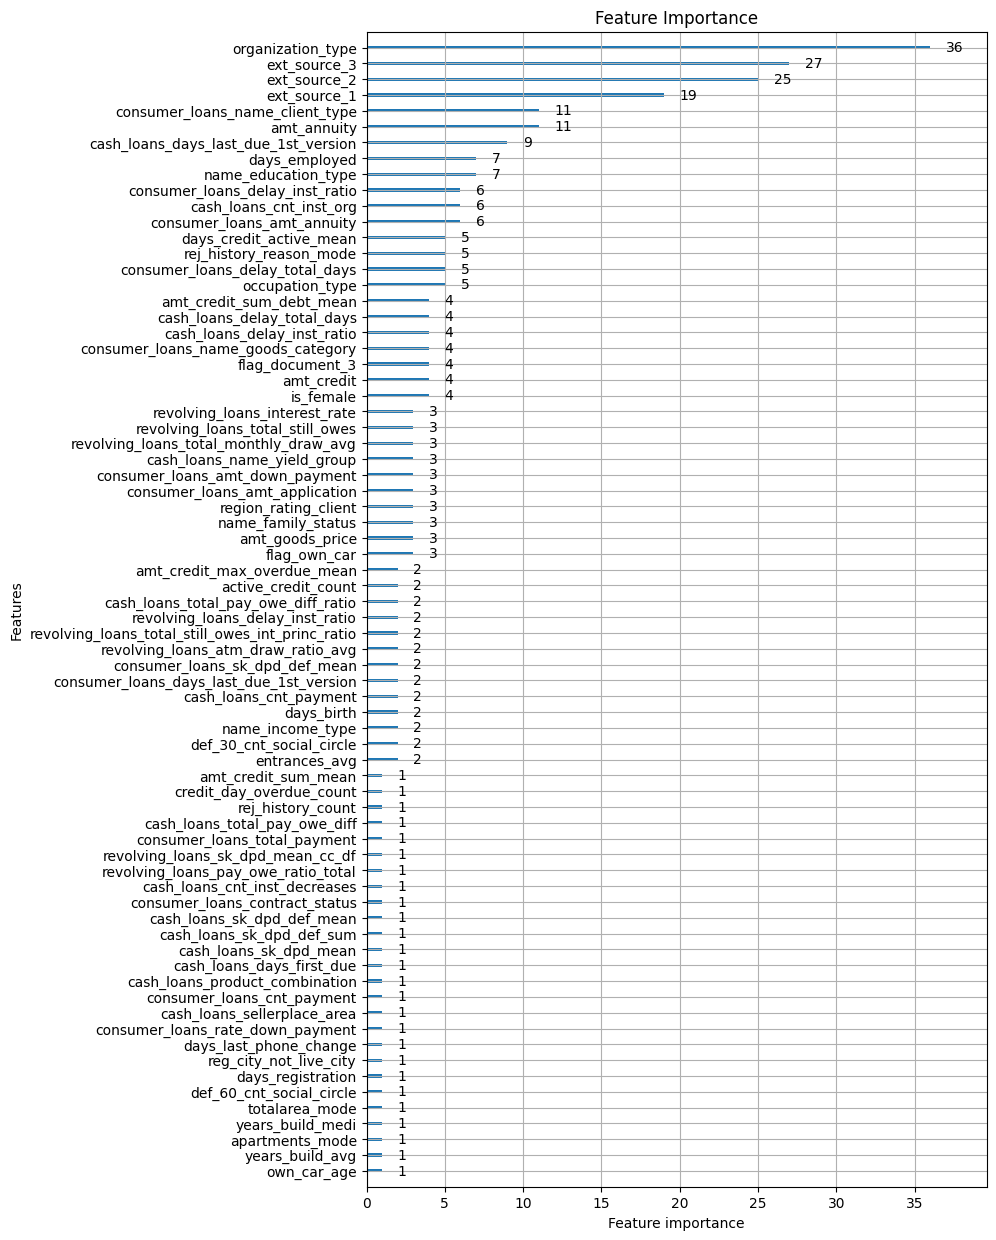

In [121]:
lgbm.plot_importance(best_lgbm, figsize=(8, 15))
plt.title("Feature Importance")
plt.show()

Model based feature selection

- Features with the highest importance are mostly coming from application table. \
=> this is sensible, since many loan applicants for Home Credit don't have \
historical loan data.

- Consumer loans and cash loans related features also have high importance. \
=> it might be that the majority of loans belongs to these two loan types.


### 💚 Kaggle Competition

In [6]:
# 14:35
selected_feats_ls = joblib.load("data/models/selected_feats_ls")
all_historical_feats_df = joblib.load("data/all_historical_feats_df")
# all_historical_feats_df[selected_feats_ls]

all_historical_feats_df

,sk_id_curr,cash_loans_amt_annuity,consumer_loans_amt_annuity,revolving_loans_amt_annuity,cash_loans_amt_application,consumer_loans_amt_application,revolving_loans_amt_application,cash_loans_amt_down_payment,consumer_loans_amt_down_payment,revolving_loans_amt_down_payment,...,currency_1_ratio,days_credit_active_mean,credit_day_overdue_mean,credit_day_overdue_count,amt_credit_max_overdue_mean,cnt_credit_prolong_mean,amt_credit_sum_mean,amt_credit_sum_debt_mean,amt_annuity_mean,status_mean
0,100002,NaN,9251.775391,NaN,NaN,179055.000000,NaN,NaN,0.000000,NaN,...,1.0,-874.000000,0.0,8.0,1681.028931,0.0,1.081319e+05,49156.199219,0.00000,0.299222
1,100003,98356.992188,35652.488281,NaN,900000.0,203154.750000,NaN,NaN,3442.500000,NaN,...,1.0,-1400.750000,0.0,4.0,0.000000,0.0,2.543501e+05,0.000000,NaN,NaN
2,100004,NaN,5357.250000,NaN,NaN,24282.000000,NaN,NaN,4860.000000,NaN,...,1.0,-867.000000,0.0,2.0,0.000000,0.0,9.451890e+04,0.000000,NaN,NaN
3,100006,32100.255859,15755.219727,13500.0,564750.0,180914.671875,270000.0,NaN,34840.171875,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,17059.253906,2717.910156,NaN,213750.0,24090.750000,NaN,NaN,3390.750000,NaN,...,1.0,-1149.000000,0.0,1.0,0.000000,0.0,1.462500e+05,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304919,456064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,-929.703674,0.0,27.0,0.000000,0.0,2.251293e+05,85639.875000,2294.59082,0.000000
304920,456155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,-1635.000000,0.0,1.0,NaN,0.0,8.938350e+04,0.000000,0.00000,0.000000
304921,456177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,-482.000000,0.0,4.0,0.000000,0.0,1.241906e+06,729735.000000,NaN,NaN
304922,456187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,-1147.000000,0.0,3.0,NaN,0.0,9.354000e+05,132298.500000,NaN,NaN


In [9]:
test = pd.read_csv("data/application_test.csv")
test = format_and_squeeze_df(test)
test_df = cast_typ_obj_to_cat(test)
test_df = test_df.merge(all_historical_feats_df, on="sk_id_curr", how="left")
test_df = down_cast_float(test_df)

test_df["is_female"] = test_df["code_gender"].apply(lambda i: 1 if i == "F" else 0)
test_df.drop(columns=["code_gender"], inplace=True)

test_df = test_df[selected_feats_ls]
joblib.dump(test_df, "data/test_df")  # save test_df

In [20]:
test_df.shape

(48744, 72)